This notebook demonstrates performance of mSSA model. It also saves/loads some data and figures. Model's parameters can be changed in the corresponding sections here.

In [24]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [25]:
import numpy as np
import scipy.linalg as linalg
from matplotlib import pyplot as plt
import pandas as pd
import pathlib

import pickle

%matplotlib inline 

In [26]:
# mssa model
from src.ssa_methods.m_ssa import m_SSA

# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
import src.data.electricity as electricity_data

# partition finding algorithms
from src.ssa_methods.ssa_complementary.ssa_multidim_partition import NextDichotomyPartition

## Data preprocessing

In [27]:
# names of observed signals
sig_names = ['Production program', 'Price']
# measure units
sig_units = ['MhW', 'TL']

num_signals = 2

In [28]:
# retrive signals and corresponding time grids
# they are already preproccessed
(train_data, time_grid_train), (test_data, time_grid_test) = electricity_data.GetTrainTestData(
    series_len=3000,
    test_ratio=0.18
)

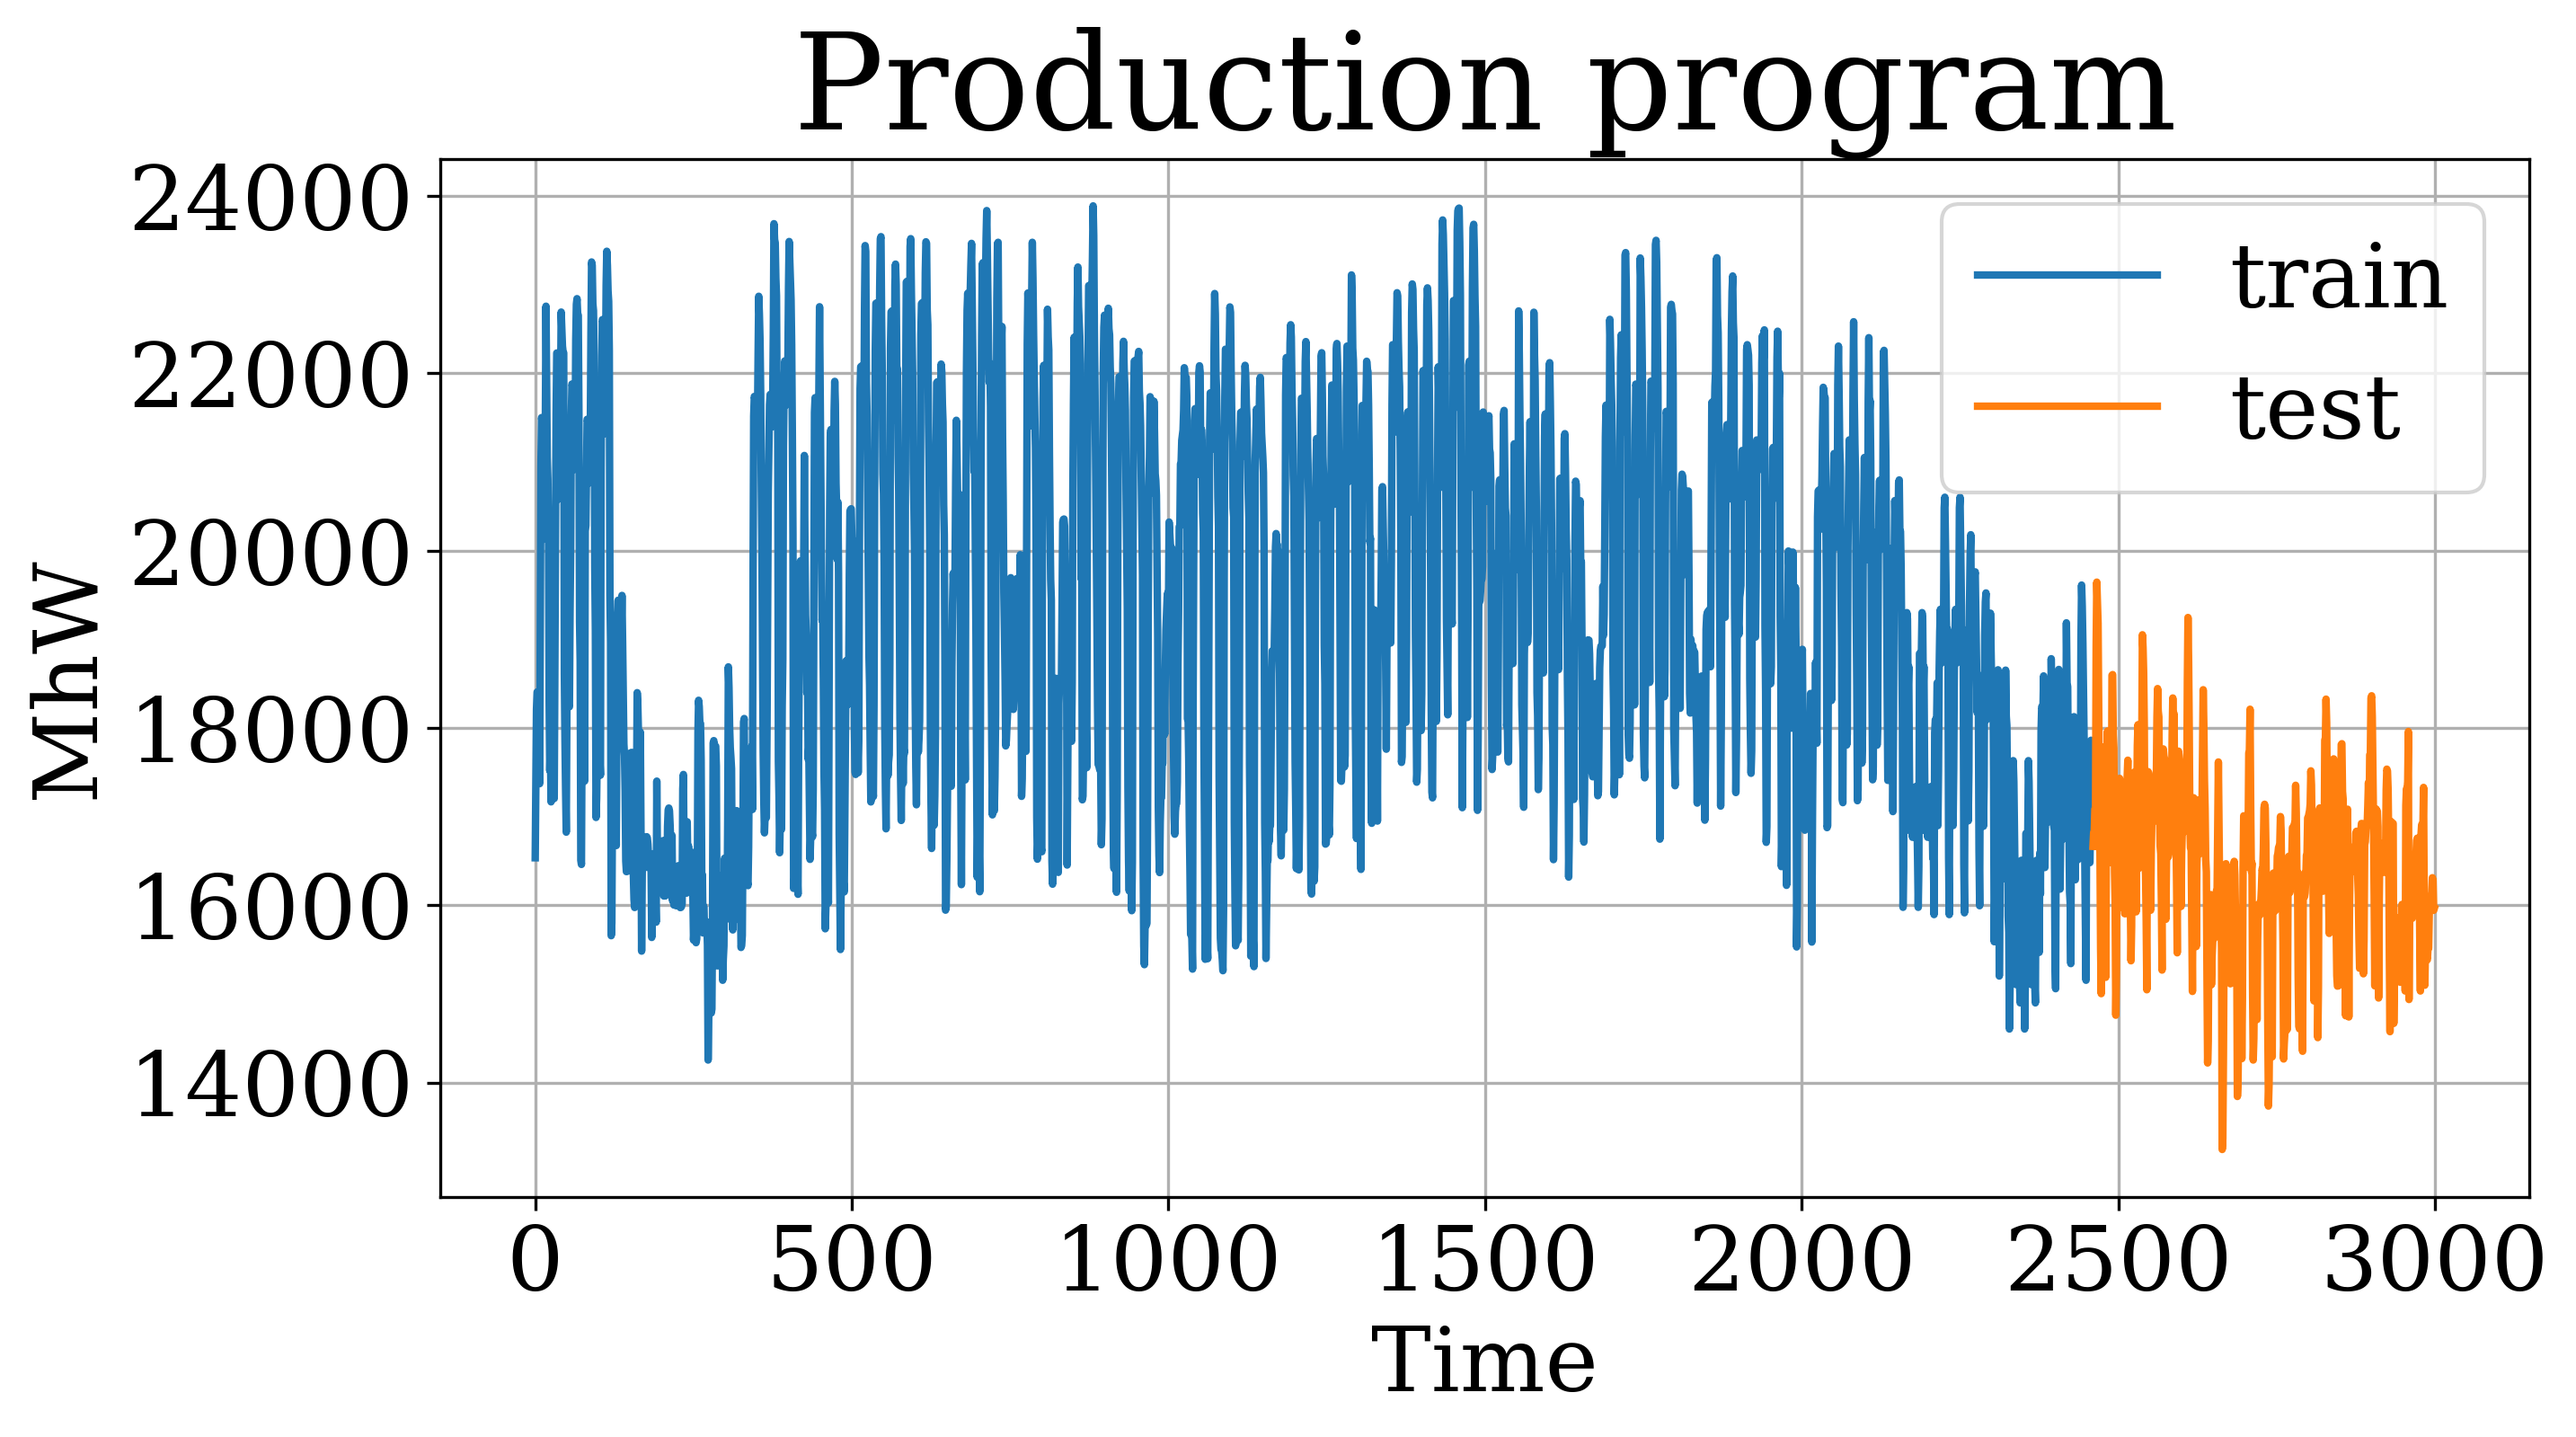

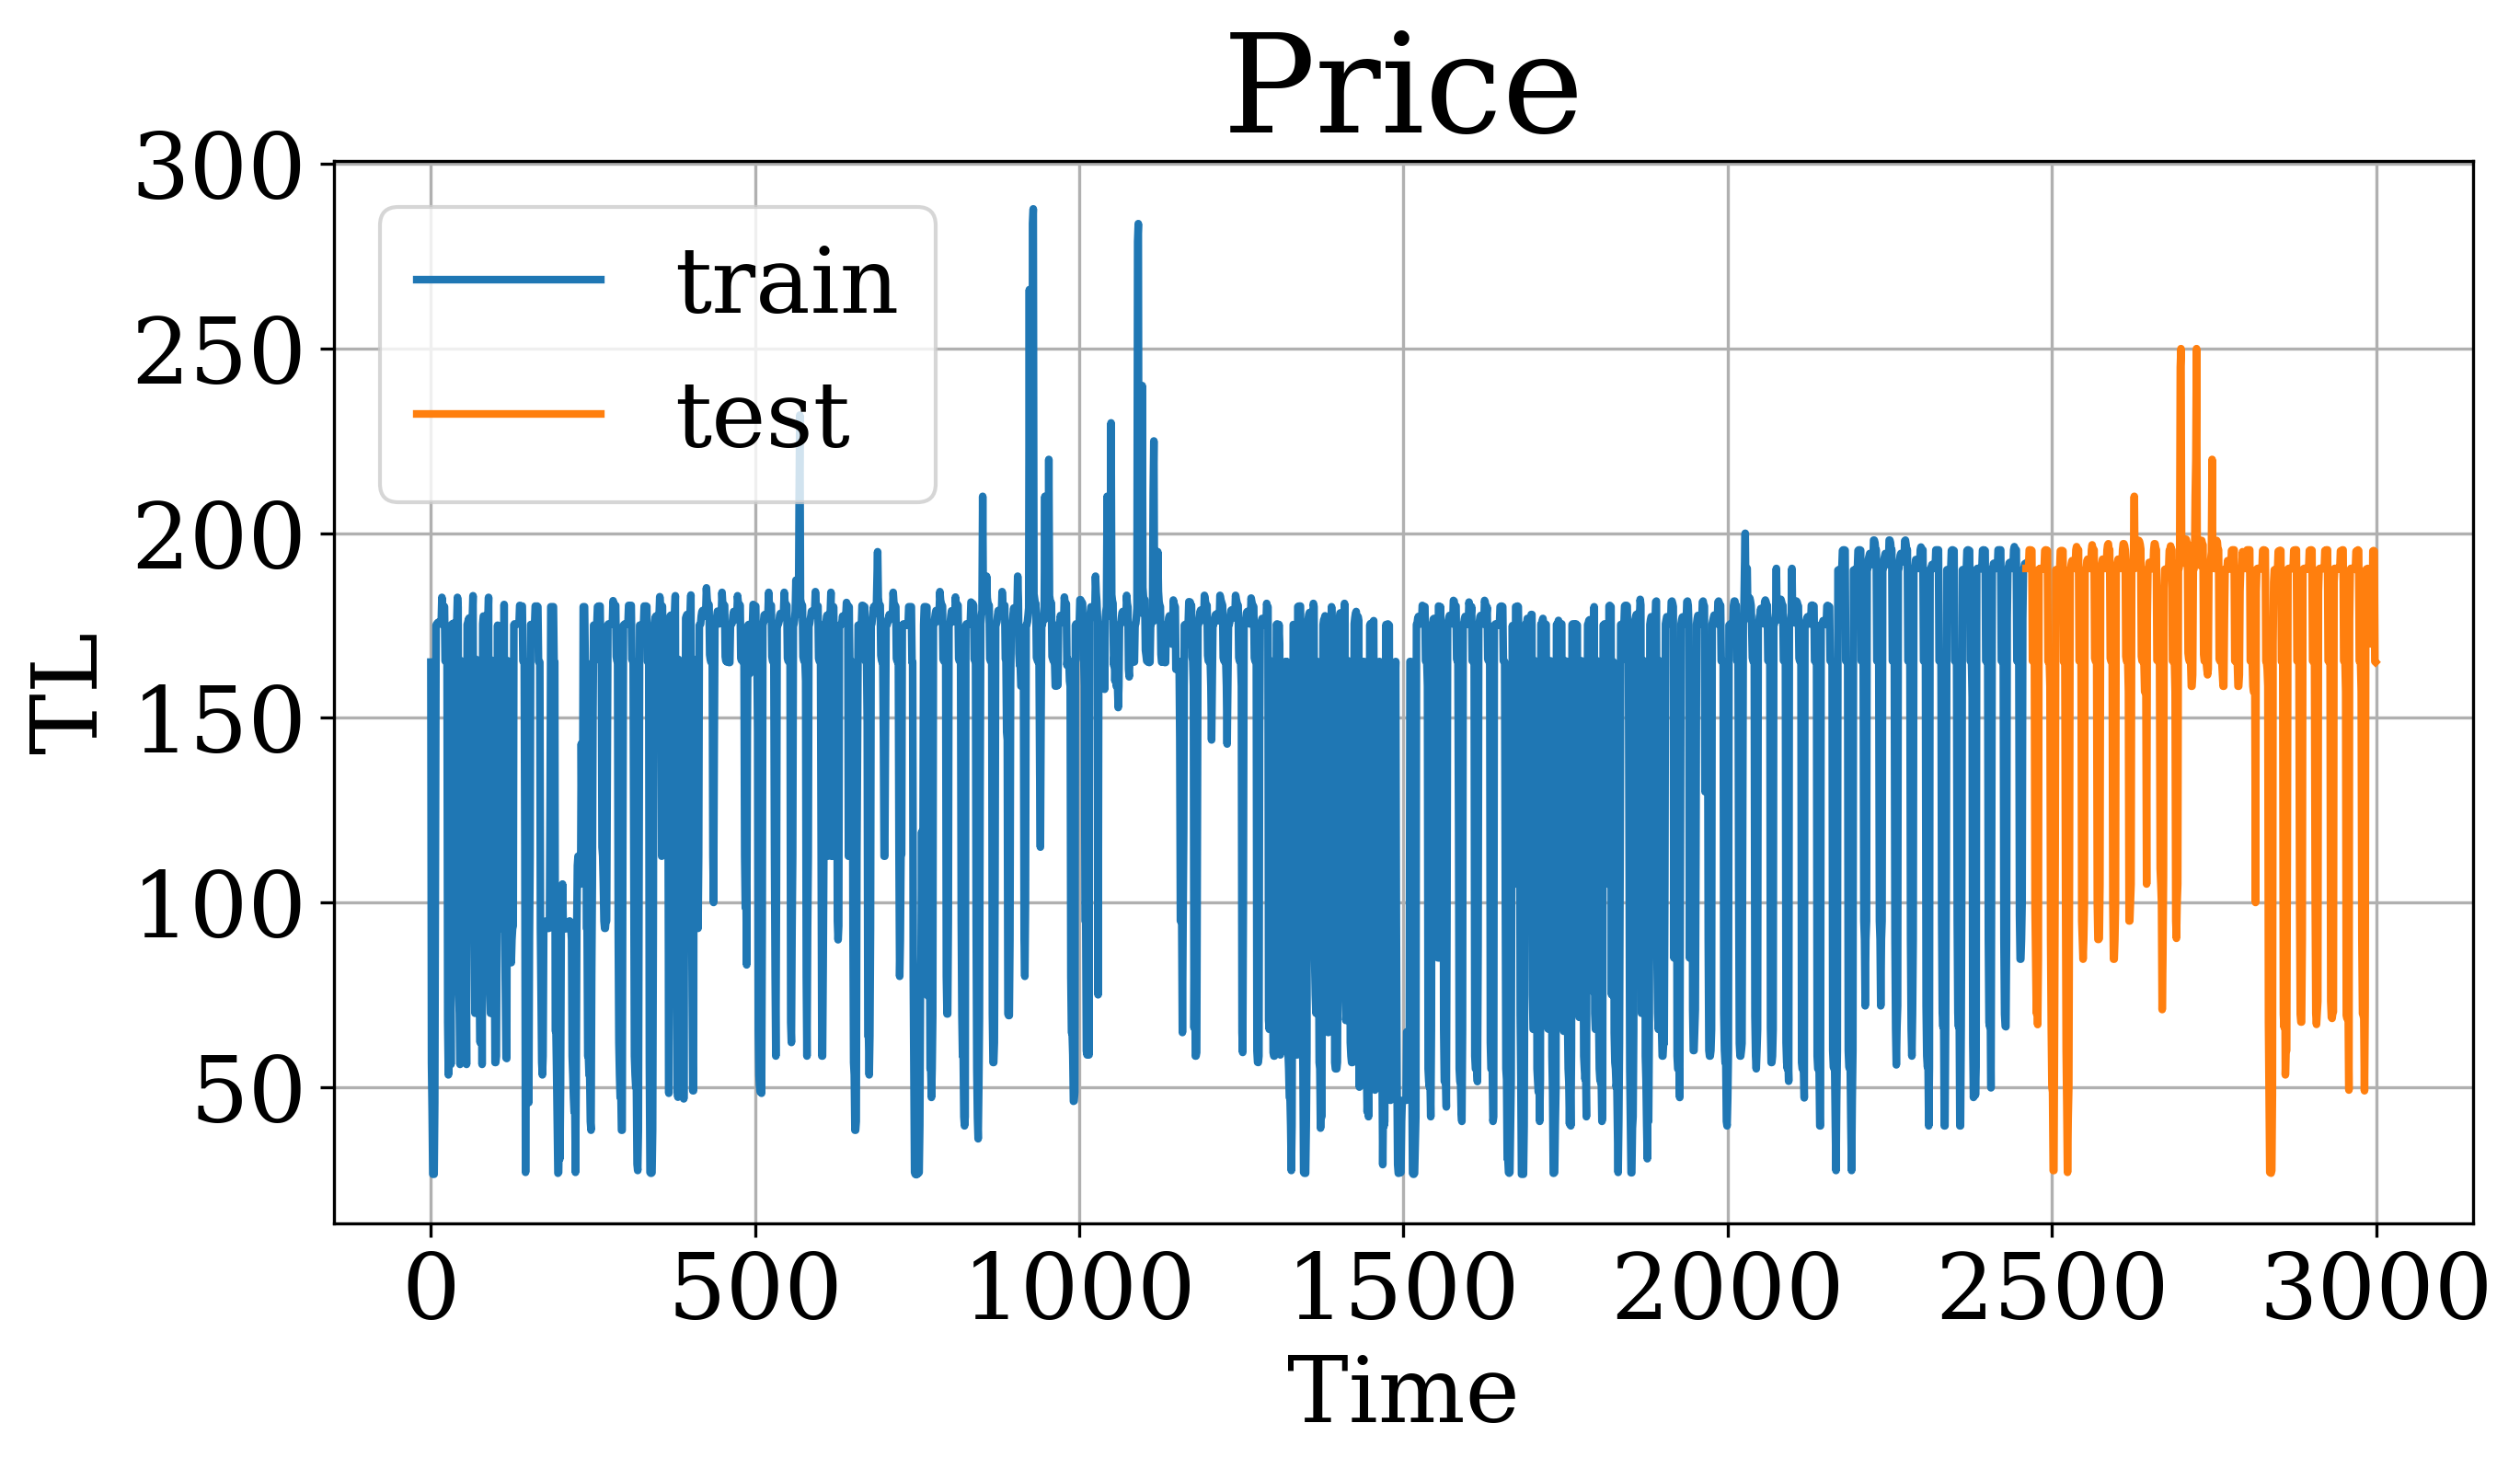

In [29]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

## Global method parameters

In [30]:
# aka L parameter
ssa_window_size = 500

## mSSA fitting

In [31]:
# make directory for models
pathlib.Path(f'./saved_model').mkdir(parents=True, exist_ok=True)

In [32]:
# load model if it already exists
if pathlib.Path(f'./saved_model/mssa_model.pkl').exists():
    with open(f'./saved_model/mssa_model.pkl', 'rb') as f:
        m_ssa_obj = pickle.load(f)
else:
    m_ssa_obj = m_SSA(ssa_window_size, train_data.T)

    # make svd for common matrix, extract factors and singular values
    m_ssa_obj.decompose_tt()

    # save model
    with open(f'./saved_model/mssa_model.pkl', 'wb') as f:
        pickle.dump(m_ssa_obj, f)

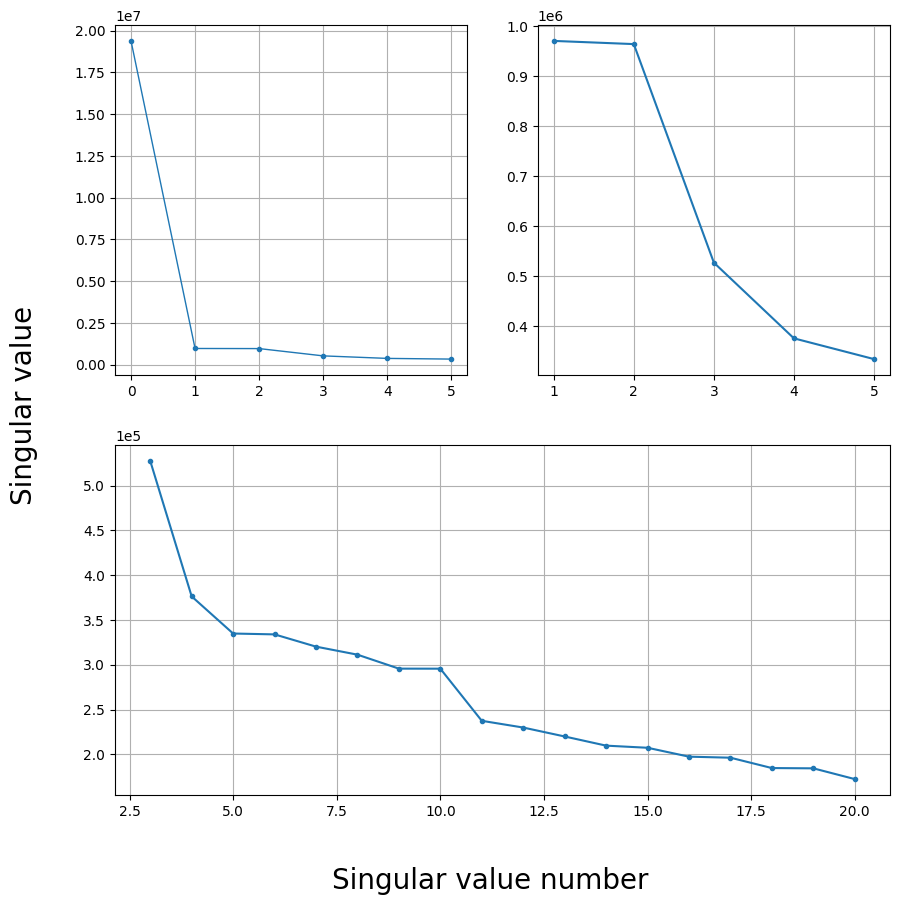

In [33]:
# have a look on singular values on diffrent scales
fig, axd = plt.subplot_mosaic([['left', 'right'], ['down', 'down']],figsize=(10, 10))

# put first 5 singular values on the left
axd['left'].plot(np.arange(0, 5 + 1), m_ssa_obj.weights[:5 + 1], marker='.', linewidth=1)
axd['left'].grid(True)

# put 2-5 singular values on the right
axd['right'].plot(np.arange(1, 5 + 1), m_ssa_obj.weights[1:5 + 1], marker='.')
axd['right'].grid(True)

# put 3-20 singular values on the right
axd['down'].plot(np.arange(3, 20 + 1, dtype=np.int16), m_ssa_obj.weights[3:20 + 1], marker='.')
axd['down'].grid(True)
axd['down'].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

fig.supxlabel('Singular value number', fontsize=20)
fig.supylabel('Singular value', fontsize=20);

In [34]:
# how many value do first k singular values keep
print(f'Value of first {11} sing.vals. store {linalg.norm(m_ssa_obj.weights[:22], ord=2) / linalg.norm(m_ssa_obj.weights, ord=2)} information')

Value of first 11 sing.vals. store 0.9990452891196189 information


Let's keep first 11 components

In [35]:
m_ssa_obj.dispose_factors(np.arange(11, len(m_ssa_obj.weights)))

0.05559866758315326

## Decomposition

In [36]:
# colours for our signals (https://colorhunt.co/palette/7f27ff9f70fdfdbf60ff8911)
color_list = ['#7F27FF', '#FF8911', '#65B741']

In [42]:
def FitAndDescribe(groups: list):
    """fit mssa object with grouping, print hankel residuals, plot signal's components

    Args:
        groups (list): 
    Returns: components figures
    """
    for i in range(train_data.shape[1]):
        m_ssa_obj.set_factors_grouping(groups[i], i)

    comp_sigs, hank_resid_abs, hank_resid_rel = m_ssa_obj.decompose_signals()

    # view relative hankerlization errors
    for i in range(train_data.shape[1]):
        print(f'Group for {sig_names[i]}: {groups[i]}')
        print(f'Rel hankel. errors for {sig_names[i]}\n{hank_resid_rel[i].tolist()}\nMean = {np.mean(hank_resid_rel[i])}\n')

    figs_container = []

    # plot results
    for i in range(train_data.shape[1]):
        with EnableJournalStylePlotting():
            fig, axs = plt.subplots(nrows=len(comp_sigs[i]), ncols=1, figsize=(16, 10))
            figs_container.append(fig)
    
            for j in range(len(comp_sigs[i])):
                axs[j].plot(time_grid_train, comp_sigs[i][j], label=f'Component {j + 1}', color=color_list[i])
    
                axs[j].tick_params(axis='y', labelsize=32, )
                if j != len(comp_sigs[i]) - 1:
                    axs[j].tick_params(axis='x', labelsize=0)
                else:
                    axs[j].tick_params(axis='x', labelsize=32)

                if i == 0:
                    axs[j].ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    
                axs[j].grid(True)
                axs[j].legend()
    
            fig.supylabel(f'{sig_units[i]}', fontsize=28)
            fig.supxlabel('$t$', fontsize=28)
            fig.suptitle(f'{sig_names[i]}', fontsize=44)
    
    return figs_container

### Manual singular values grouping

In [43]:
# make directory for figures
pathlib.Path(f'./figs/decomposition/manual').mkdir(parents=True, exist_ok=True)

# make directory for groupings
pathlib.Path(f'./saved_grouping/manual').mkdir(parents=True, exist_ok=True)

Group for Production program: [[0], [1, 2], [3], [4, 5, 6, 7, 8, 9, 10]]
Rel hankel. errors for Production program
[0.01593896430375837, 0.13180371076466035, 0.711835232633395, 0.3740991784701046]
Mean = 0.3084192715429796

Group for Price: [[0], [1, 2], [3], [4, 5, 6, 7, 8, 9, 10]]
Rel hankel. errors for Price
[0.04752196510324368, 0.12236562851211341, 0.7531468530826916, 0.3172464696249939]
Mean = 0.31007022908076065



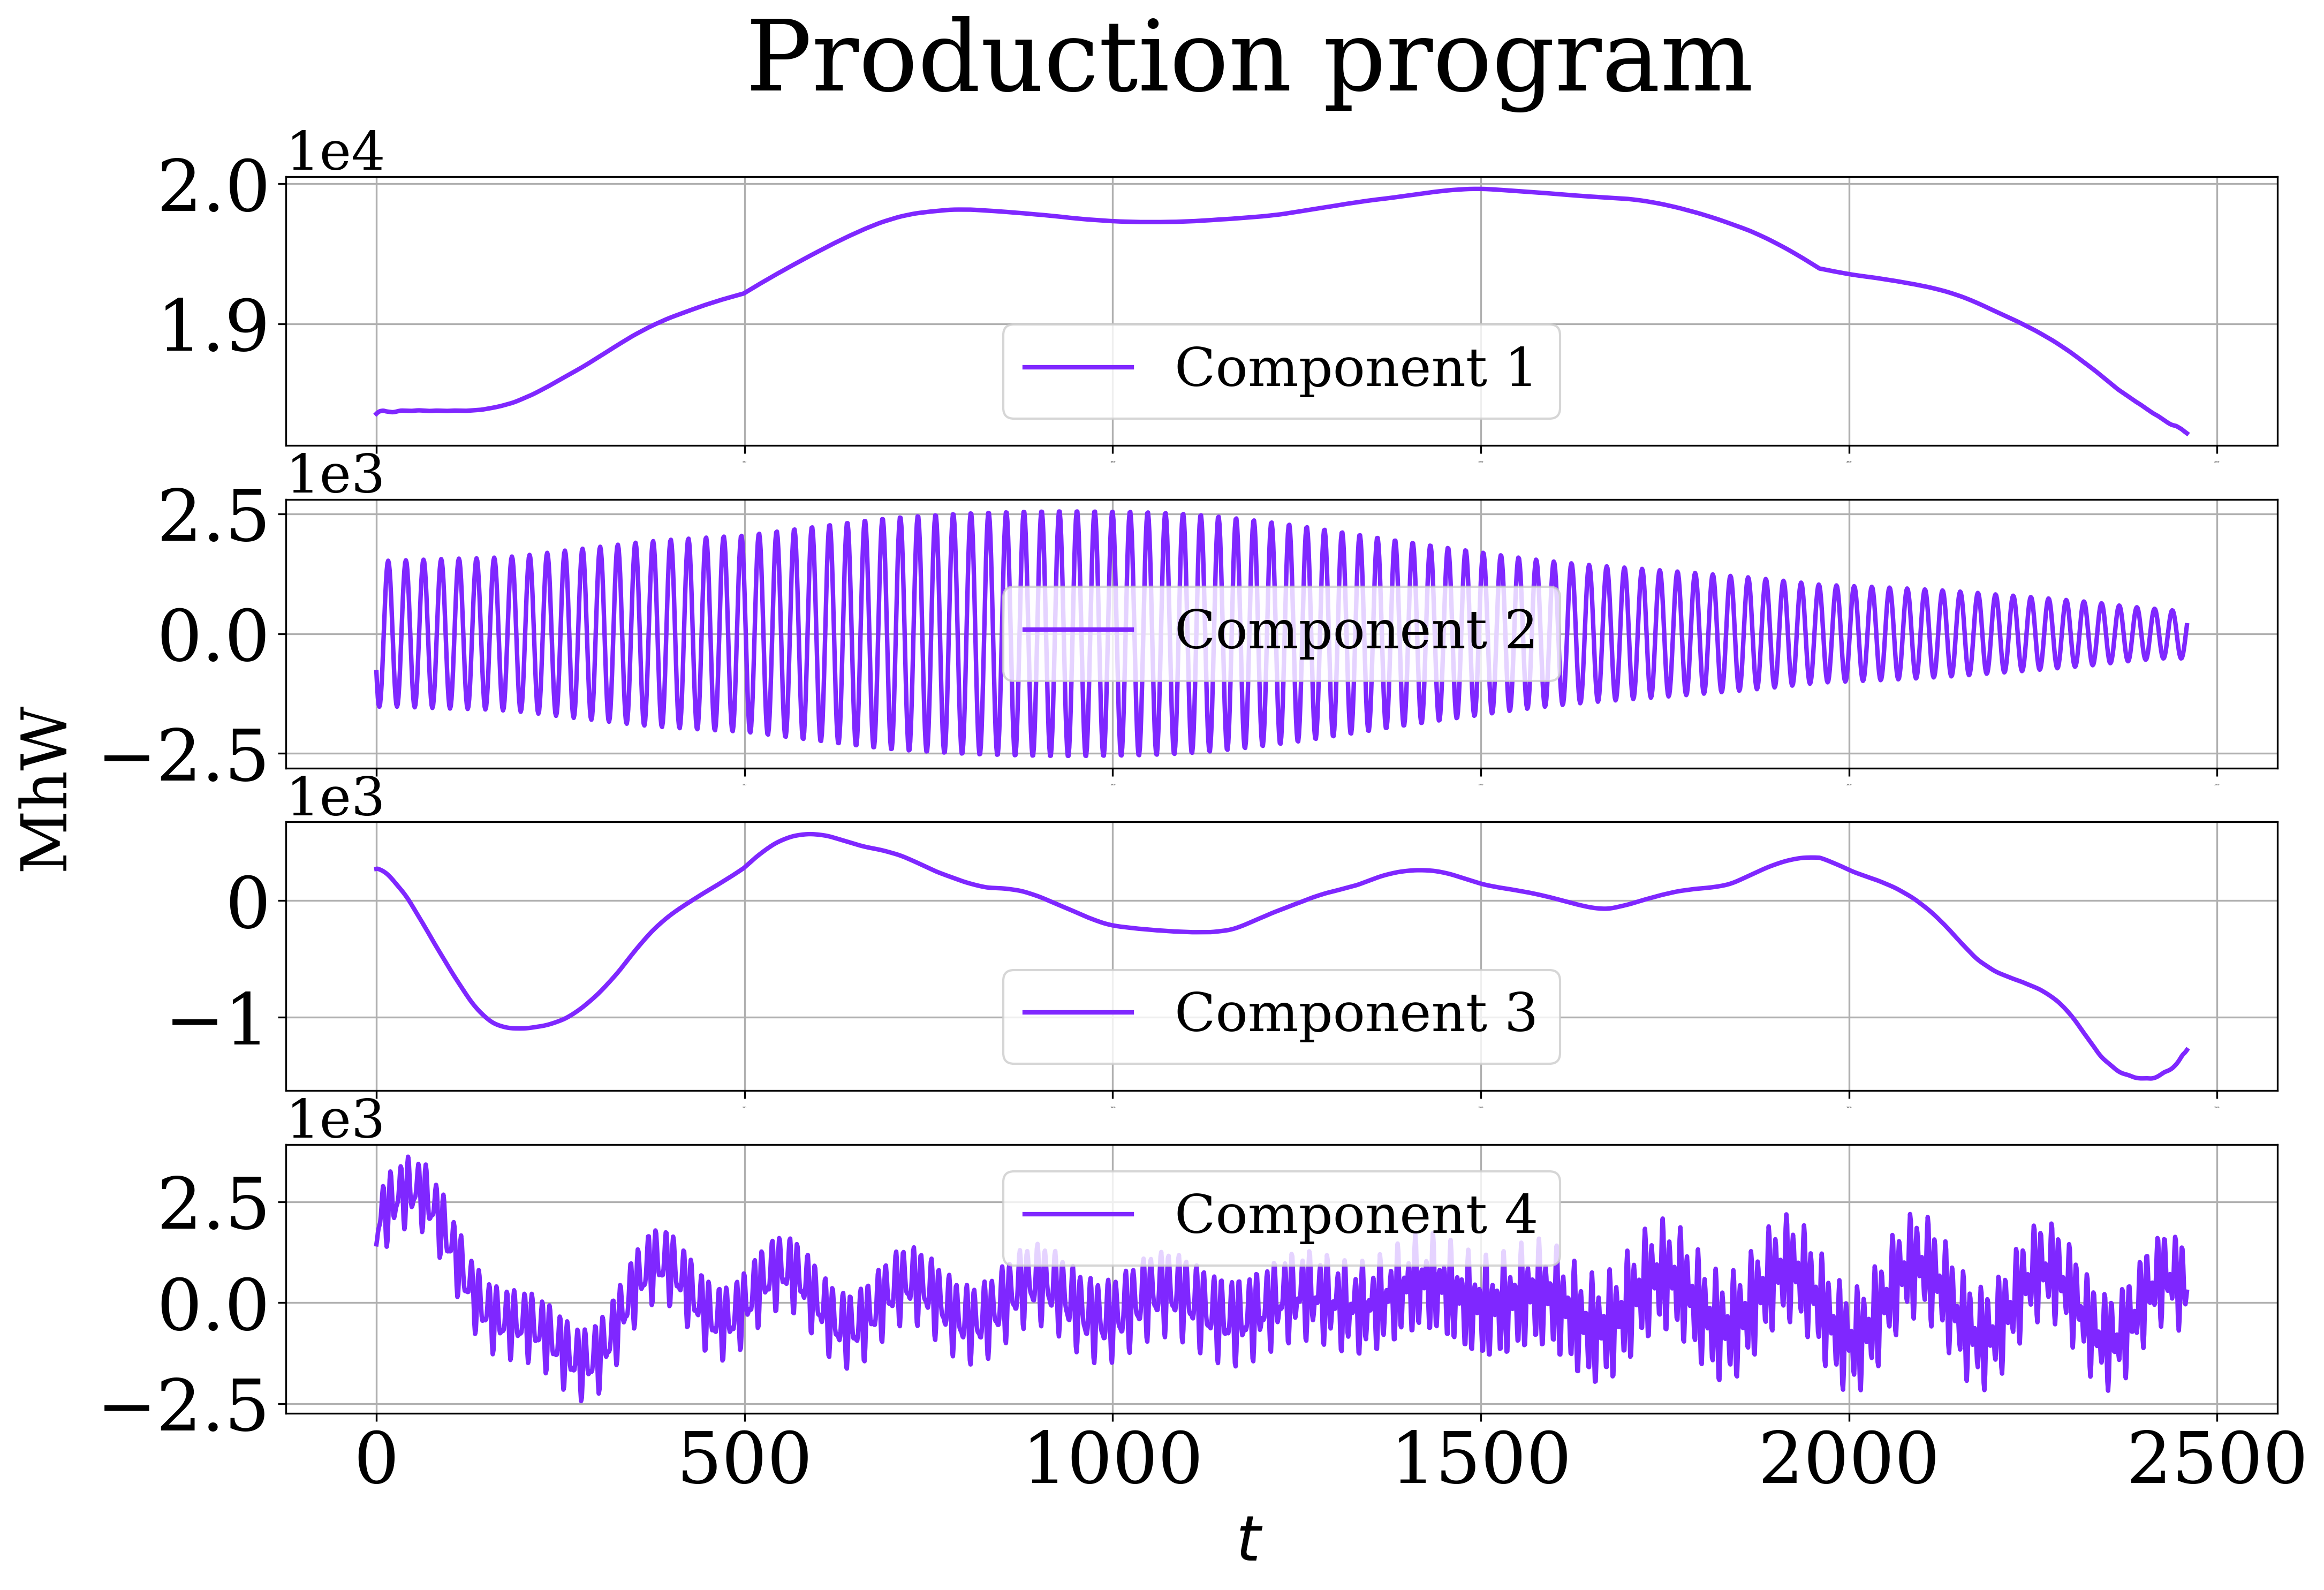

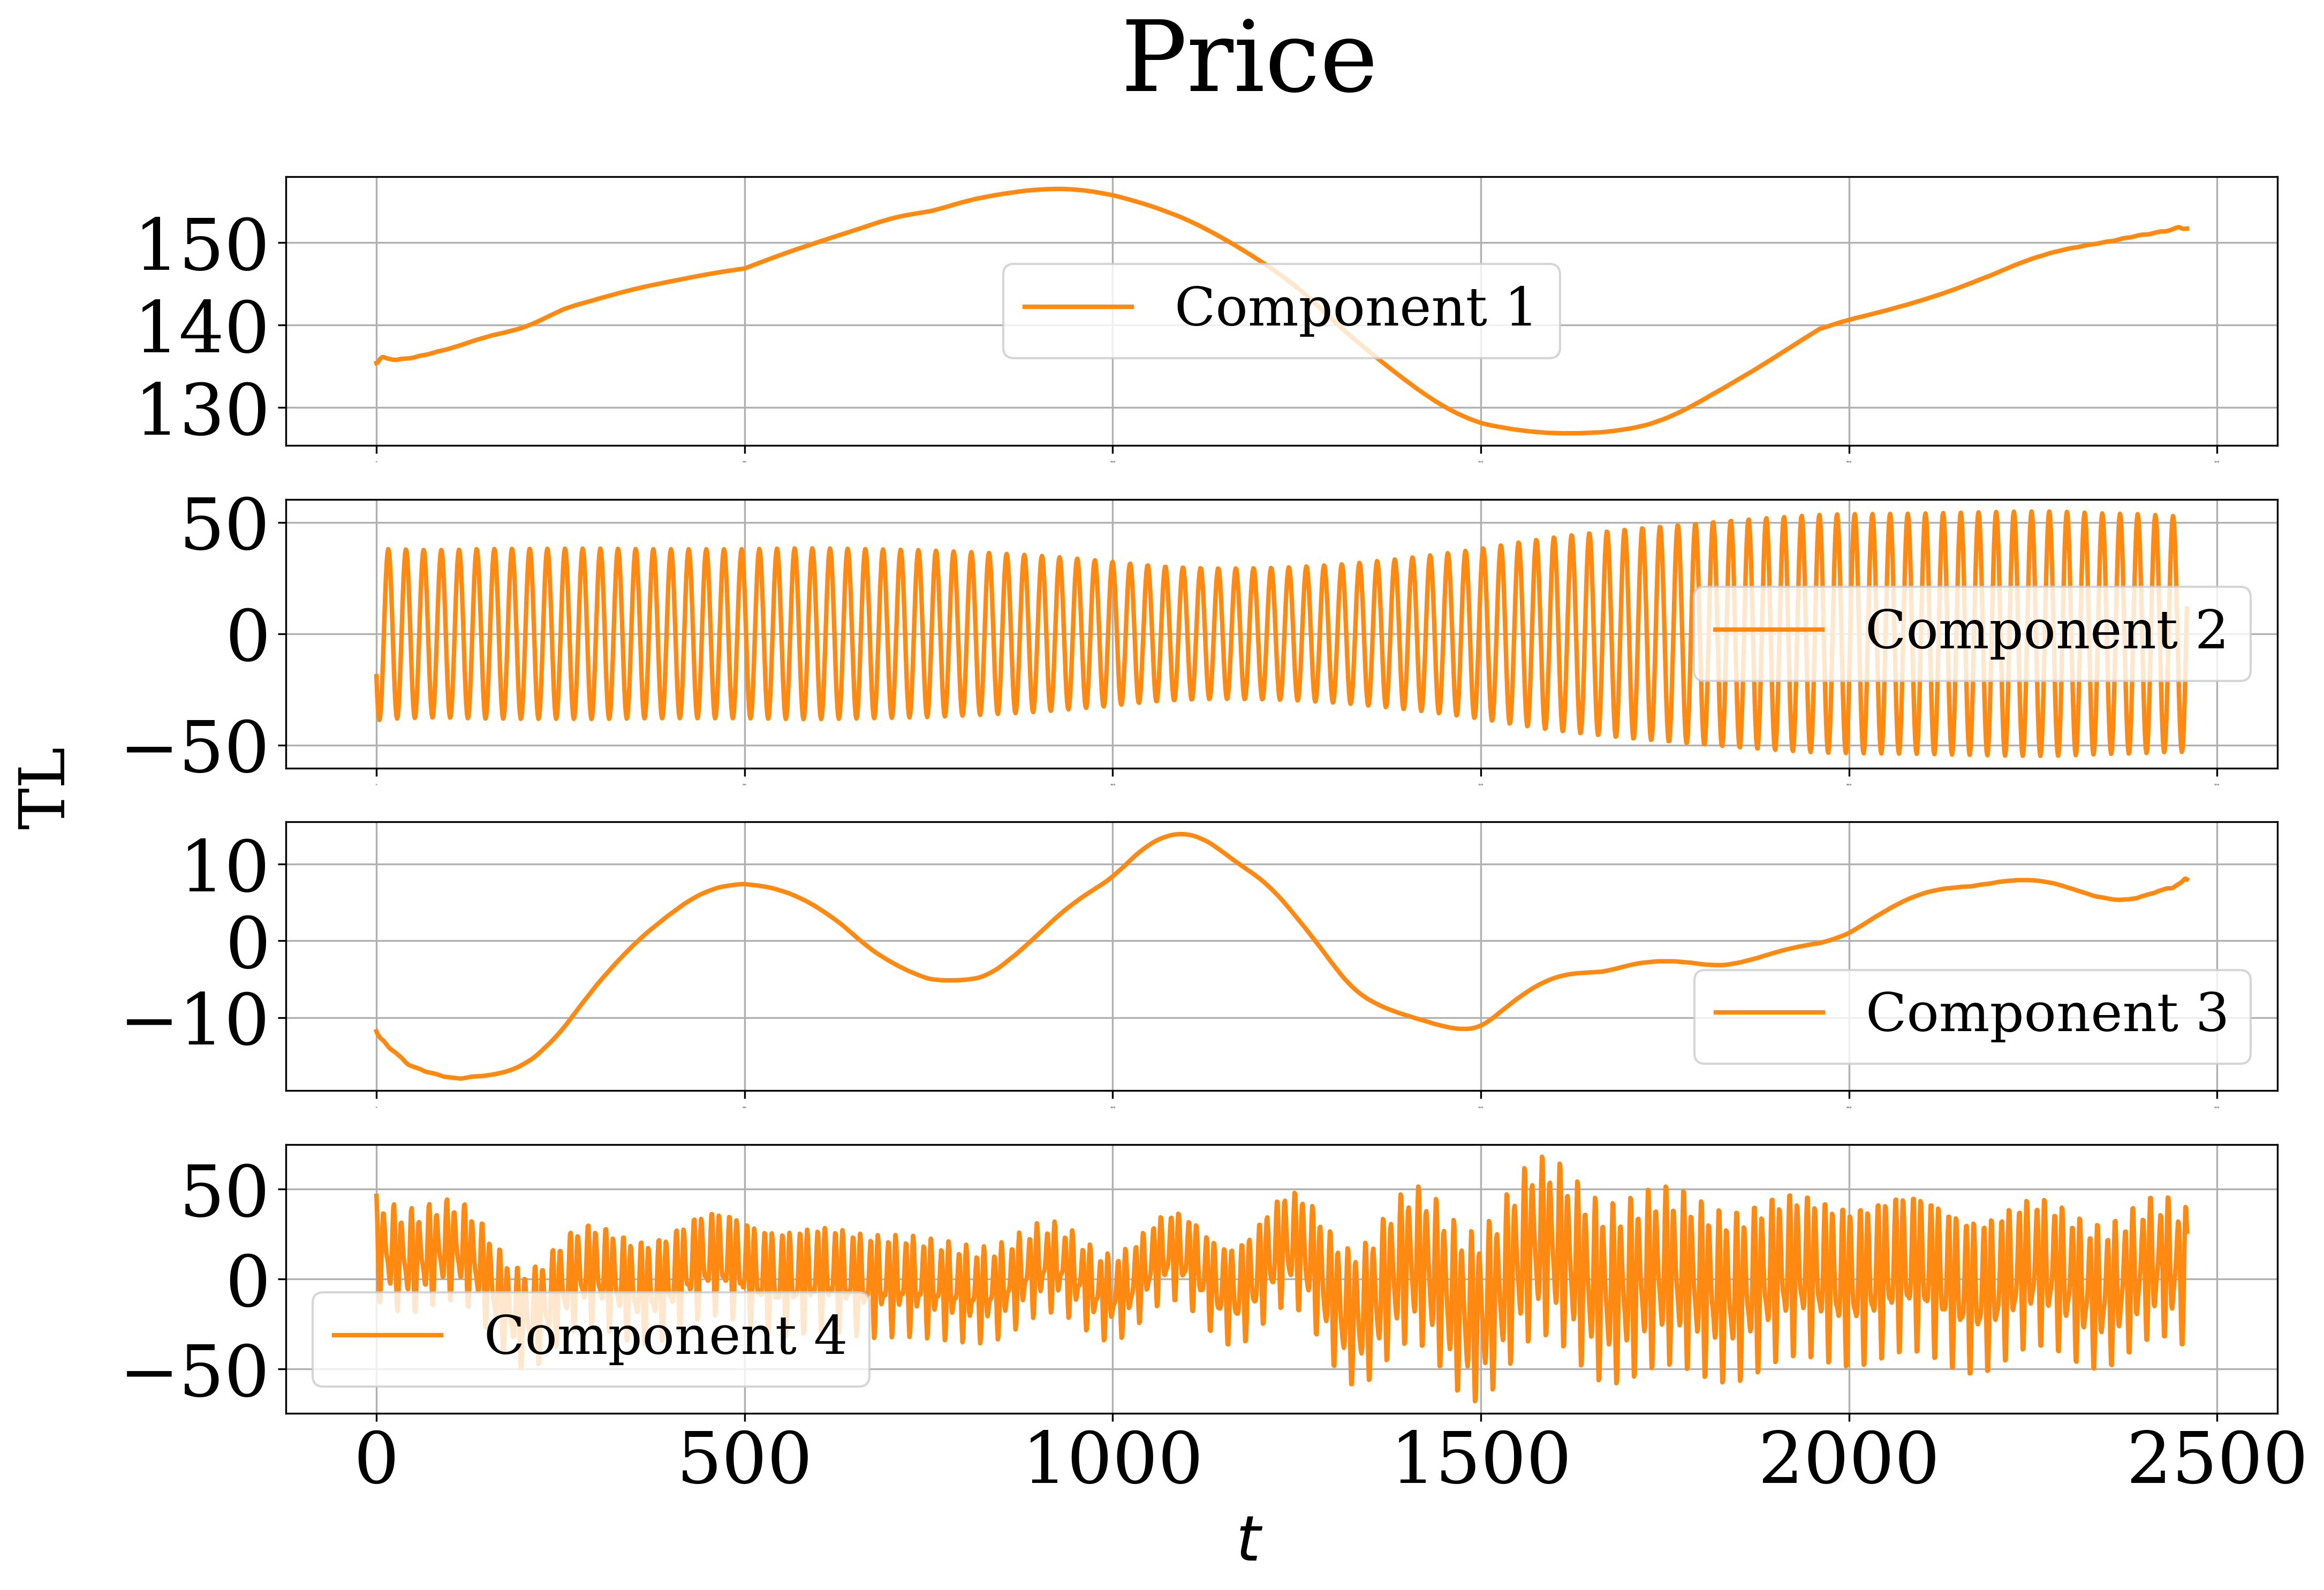

In [44]:
# every signal has the same grouping
my_grouping = [[[0, ], [1, 2], [3, ], [4, 5, 6, 7, 8, 9, 10]] for _ in range(num_signals)]
my_grouping_id = 1

# save chosen grouping
#with open(f'./saved_grouping/manual/grouping_{my_grouping_id}.pkl', 'wb') as f:
#    pickle.dump(my_grouping, f)

component_figs = FitAndDescribe(my_grouping)

# make directory for figures for chosen grouping
pathlib.Path(f'./figs/decomposition/manual/grouping_{my_grouping_id}').mkdir(parents=True, exist_ok=True)

# save figures
for i in range(len(component_figs)):
    component_figs[i].savefig(
        f'./figs/decomposition/manual/grouping_{my_grouping_id}/{sig_names[i].replace(" ", "_")}.png',
        format='png'
    )

### Dichotomy

### Use precomputed groupings

In [15]:
# enter existing group id or leave it None
existing_group_id = None

if pathlib.Path(f'./saved_grouping/dichotomy/grouping_{existing_group_id}.pkl').exists():
    with open(f'./saved_grouping/dichotomy/grouping_{existing_group_id}.pkl', 'rb') as f:
        dichy_groups = pickle.load(f)

    # use grouping and obtain decomposition results
    component_figs = FitAndDescribe(dichy_groups)
    # may safe
    ...
else:
    print('No saved grouping')

No saved grouping


### Disect existing grouping or build new

In [19]:
# flag controlling execution of this section
want_to_disect = True

In [20]:
# creating grouping generator
if want_to_disect:
    # enter group id to further disect or None
    existing_group_id = None

    # load initial grouping
    if pathlib.Path(f'./saved_grouping/dichotomy/grouping_{existing_group_id}.pkl').exists():
        with open(f'./saved_grouping/dichotomy/grouping_{existing_group_id}.pkl', 'rb') as f:
            init_dichy_groups = pickle.load(f)
    # go from the start
    else:
        init_dichy_groups = None

    # create grouping generator
    DichPartitionGenerator = NextDichotomyPartition(m_ssa_obj, init_dichy_groups)

Group for Production program: [[0, 1, 2, 3, 4, 5, 6, 7, 8], [9, 10]]
Rel hankel. errors for Production program
[0.01576498088809352, 0.17070419368109]
Mean = 0.09323458728459176

Group for Price: [[0, 1, 2, 3, 4, 5, 6, 7, 8], [9, 10]]
Rel hankel. errors for Price
[0.052565866984729114, 0.22596693172039076]
Mean = 0.13926639935255994



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


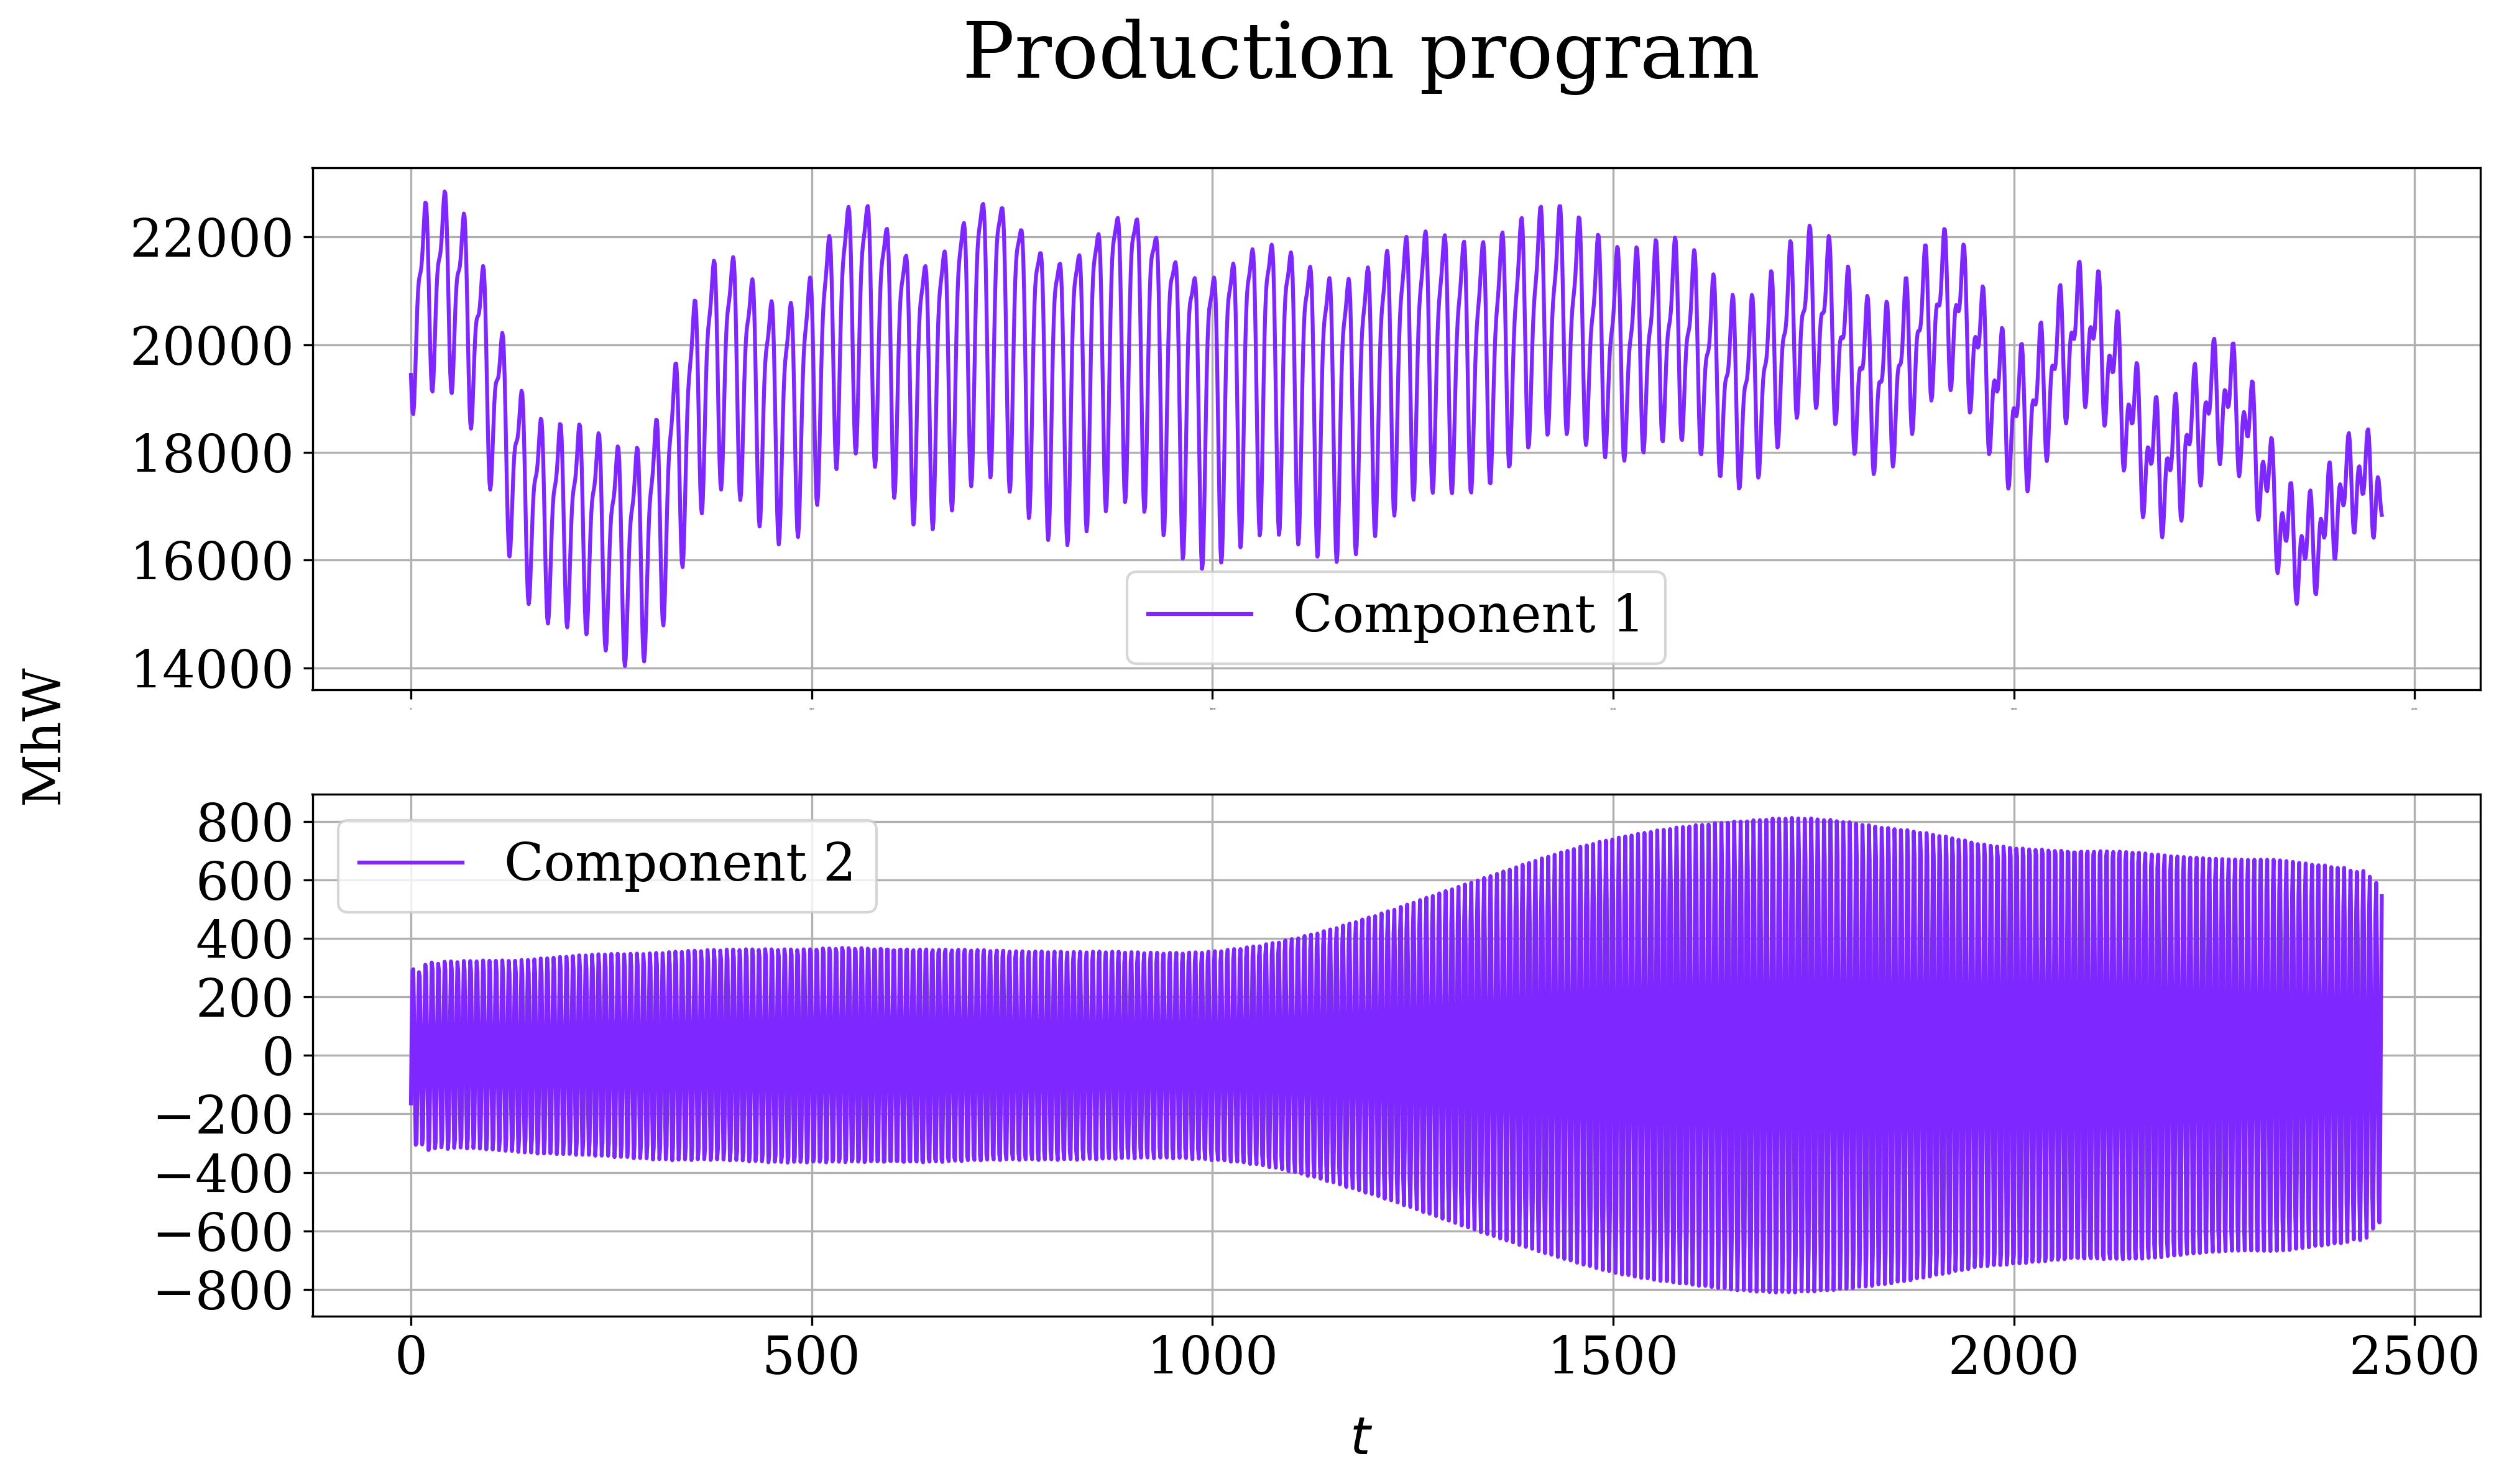

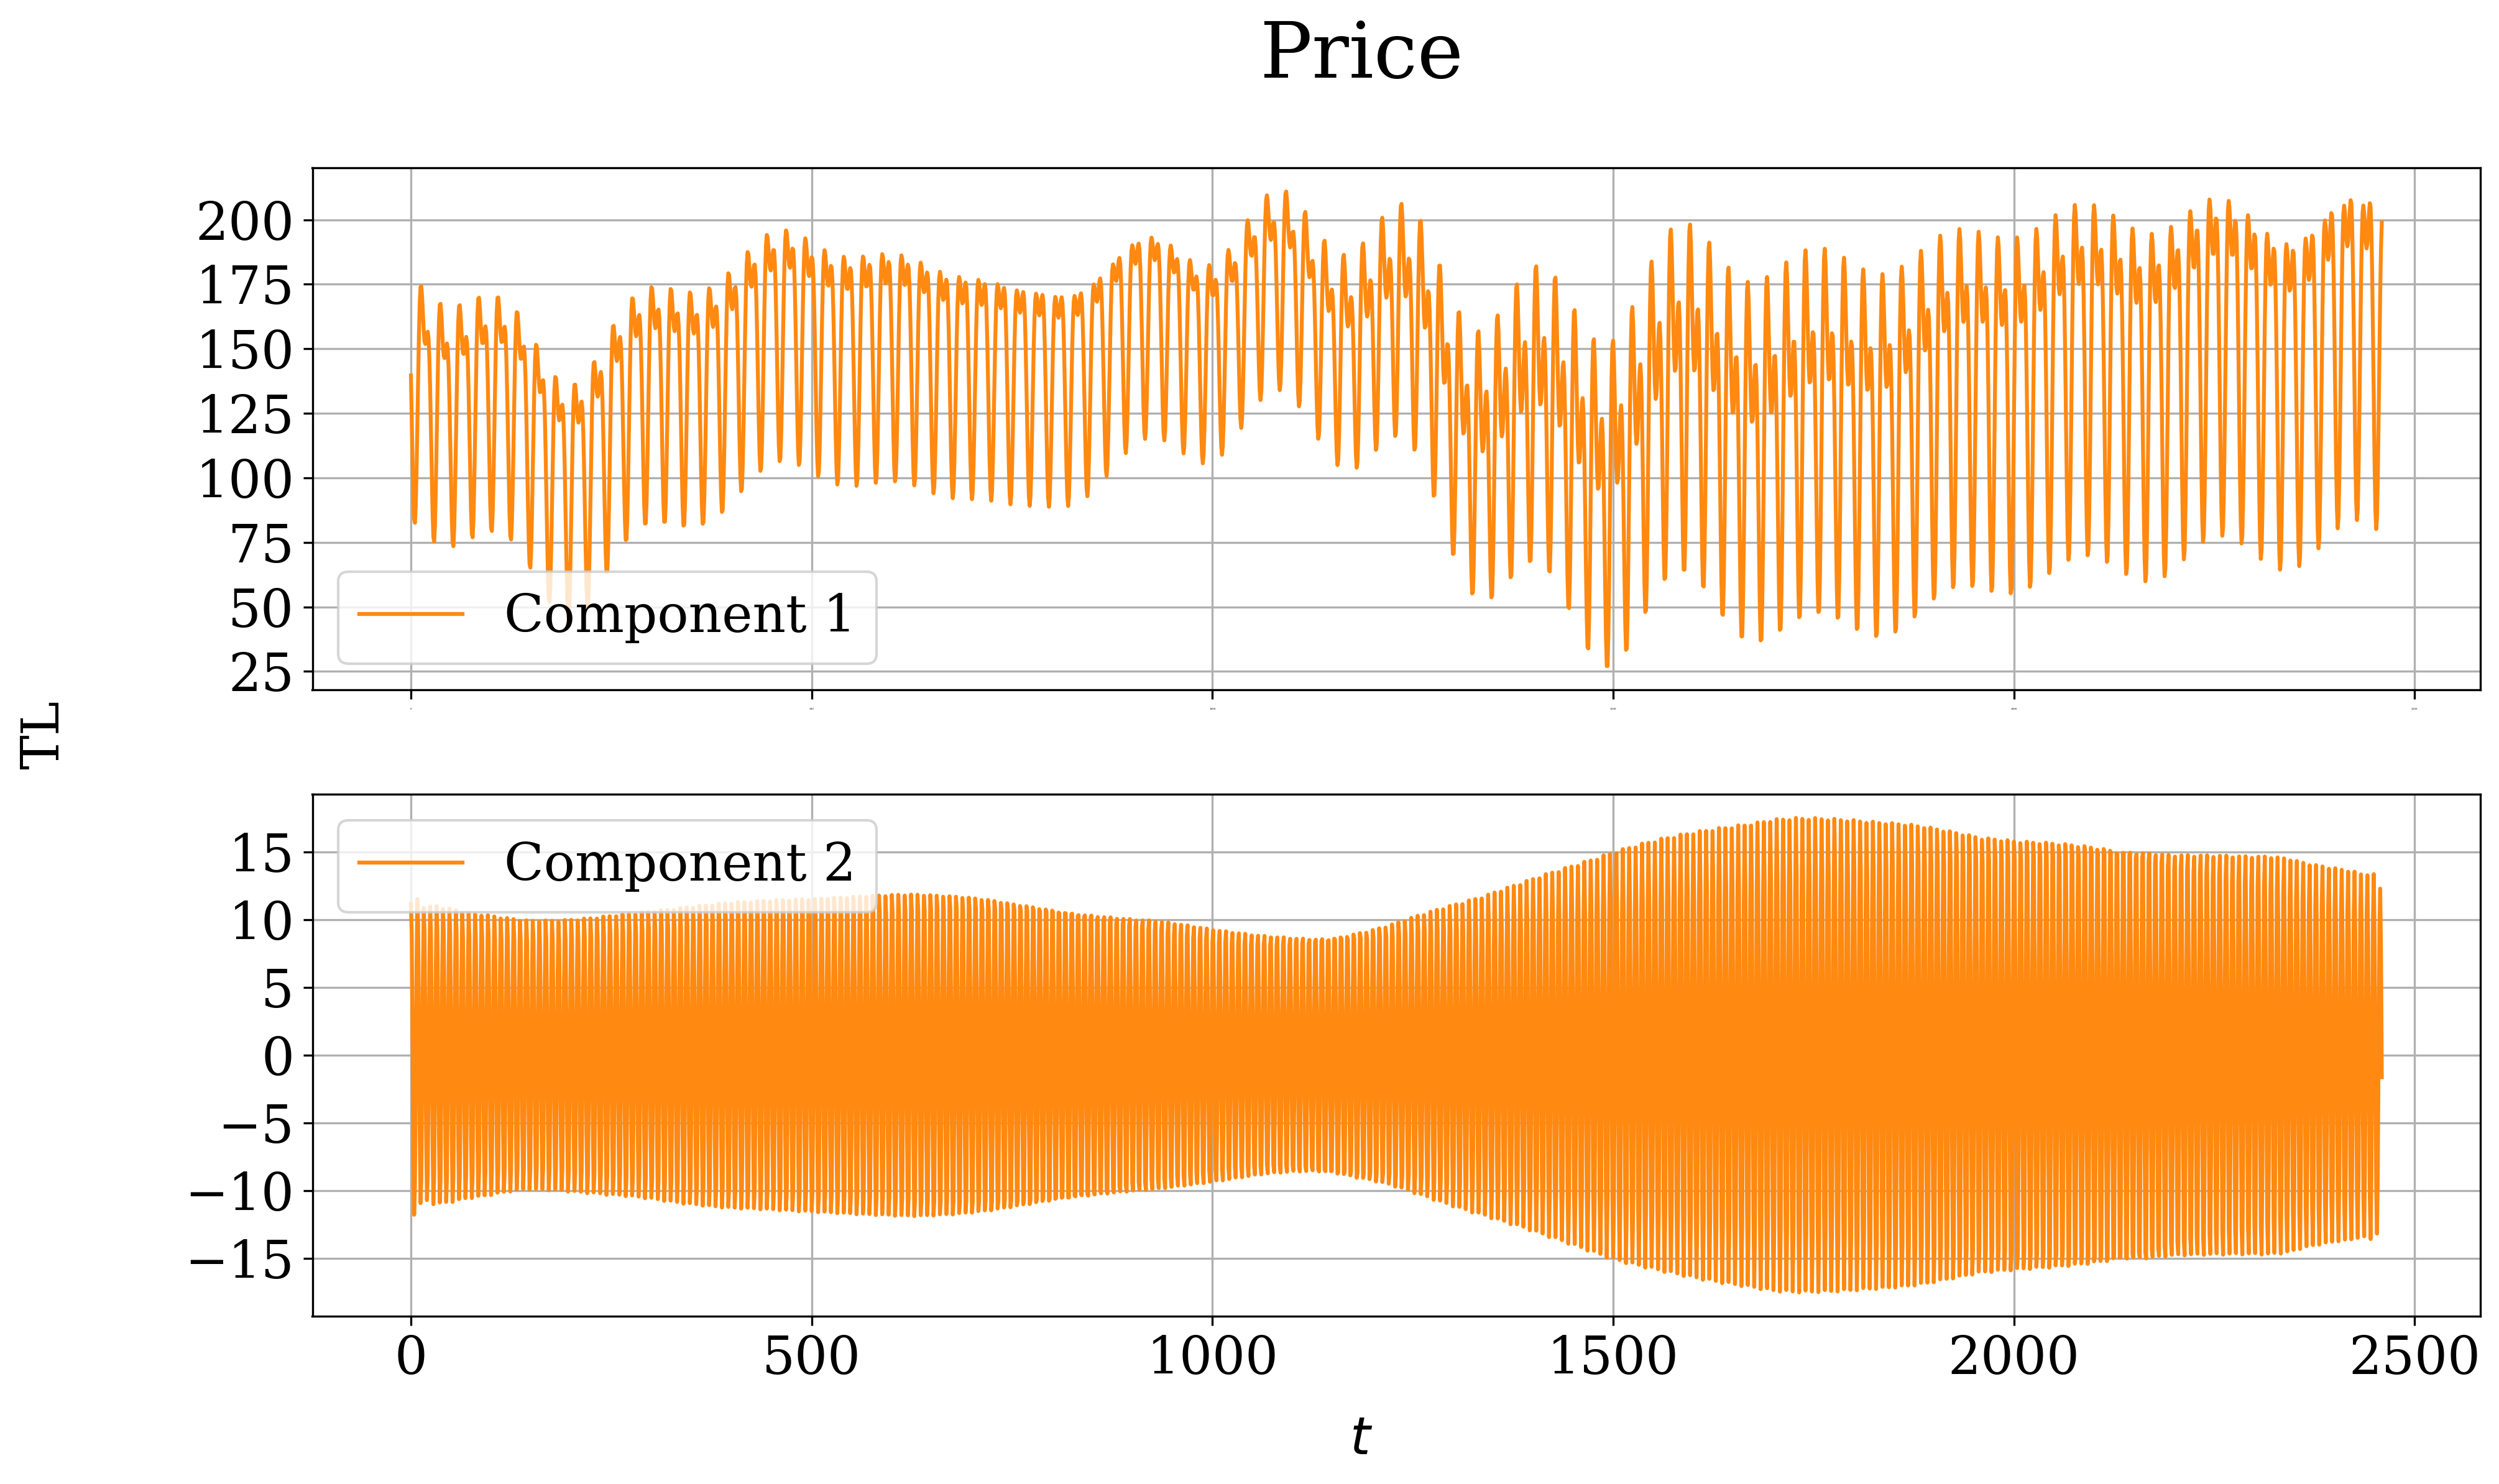

In [21]:
# initialzing generator
if want_to_disect:
    # case: we build grouping from the start
    if init_dichy_groups is None:
        dichy_groups, dichy_hankel_resids = next(DichPartitionGenerator)

        # save generated grouping
        pathlib.Path(f'./saved_grouping/dichotomy/grouping_1').mkdir(parents=True, exist_ok=True)
        with open(f'./saved_grouping/dichotomy/grouping_1.pkl', 'wb') as f:
            pickle.dump(dichy_groups, f)

        # use our grouping and obtain decomposition results
        component_figs = FitAndDescribe(dichy_groups)

        # make directory for figures (grouping on two always have index 1)
        pathlib.Path(f'./figs/decomposition/dichotomy/grouping_1').mkdir(parents=True, exist_ok=True)

        # save figures
        for i in range(len(component_figs)):
            component_figs[i].savefig(
                f'./figs/decomposition/dichotomy/grouping_1/{sig_names[i].replace(" ", "_")}.eps',
                format='eps'
            )
    else:
        # we just initialize our generator
        next(DichPartitionGenerator)

In [ ]:
# use generator
if want_to_disect:
    # execute this cell as many times as needed changing 'groups_to_disect'
    # this is the list of groups to futher disect for each signal
    
    # disect chosen groups into two more
    groups_to_disect = [[0], [0]]
    # enter unique grouping id (not 1)
    grouping_id = 2
    
    if (groups_to_disect is not None) and (grouping_id is not None):
        dichy_groups, dichy_hankel_resids = DichPartitionGenerator.send(groups_to_disect)

        # save generated grouping
        with open(f'./saved_grouping/dichotomy/grouping_{grouping_id}.pkl', 'wb') as f:
            pickle.dump(dichy_groups, f)
    
        component_figs = FitAndDescribe(dichy_groups)

        # make directory for figures (grouping on two always have index 1)
        pathlib.Path(f'./figs/decomposition/dichotomy/grouping_{grouping_id}').mkdir(parents=True, exist_ok=True)

        # save figures
        for i in range(len(component_figs)):
            component_figs[i].savefig(
                f'./figs/decomposition/dichotomy/grouping_{grouping_id}/{sig_names[i].replace(" ", "_")}.eps',
                format='eps'
            )

## Prediction

In [17]:
# make directory for figures
pathlib.Path(f'./figs/prediction').mkdir(parents=True, exist_ok=True)

In [18]:
m_ssa_obj.remove_last_predictions()

# get prediction for cuurent number of factors left
forecast_mssa = np.empty(test_data.shape)

for i in range(test_data.shape[0]):
    forecast_mssa[i] = np.array(m_ssa_obj.predict_next())

# get MSE for every signal
signals_mse_mssa = np.mean((forecast_mssa - test_data) ** 2, axis=0)
# get MAPE for every signal
signals_mape_mssa = np.mean(np.abs((forecast_mssa - test_data) / test_data), axis=0)

print(f'MSE: {signals_mse_mssa}; Mean by signals = {np.mean(signals_mse_mssa):e}')
print(f'MAPE: {signals_mape_mssa}; Mean by signals = {np.mean(signals_mape_mssa)}')

MSE: [1.50580834e+06 1.02720777e+03]; Mean by signals = 7.534178e+05
MAPE: [0.05965507 0.16942773]; Mean by signals = 0.11454140142856073


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


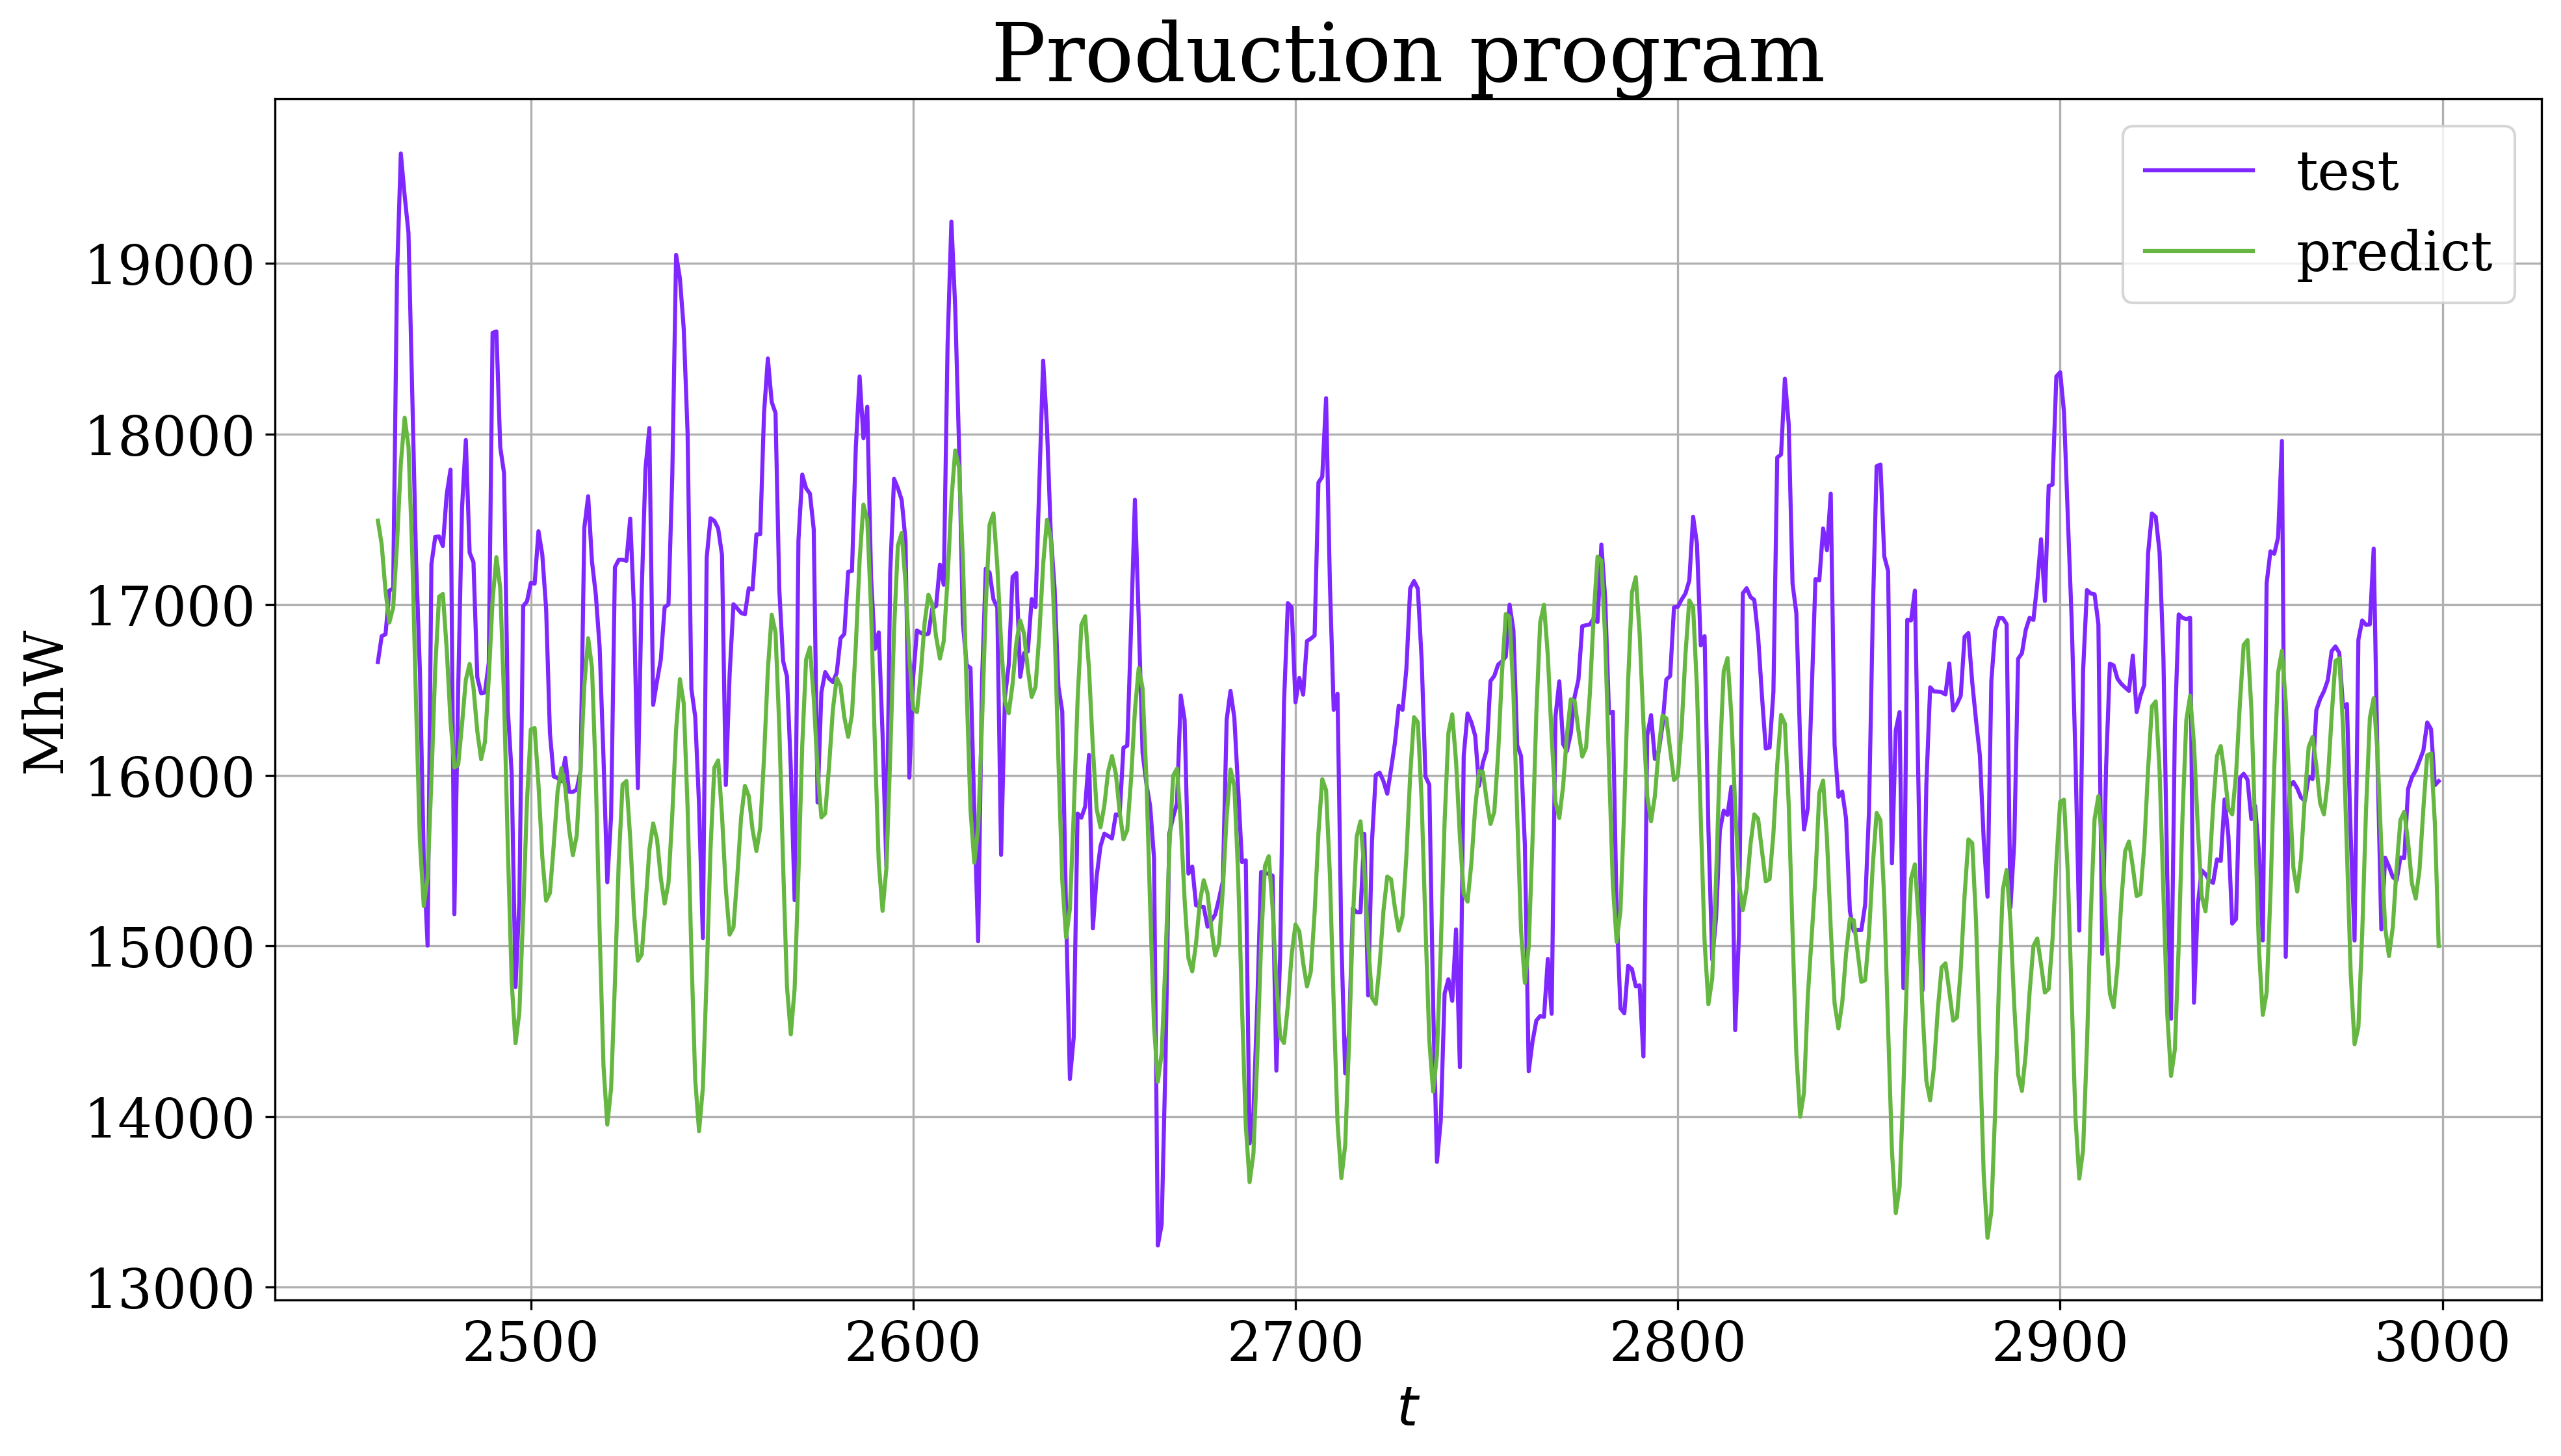

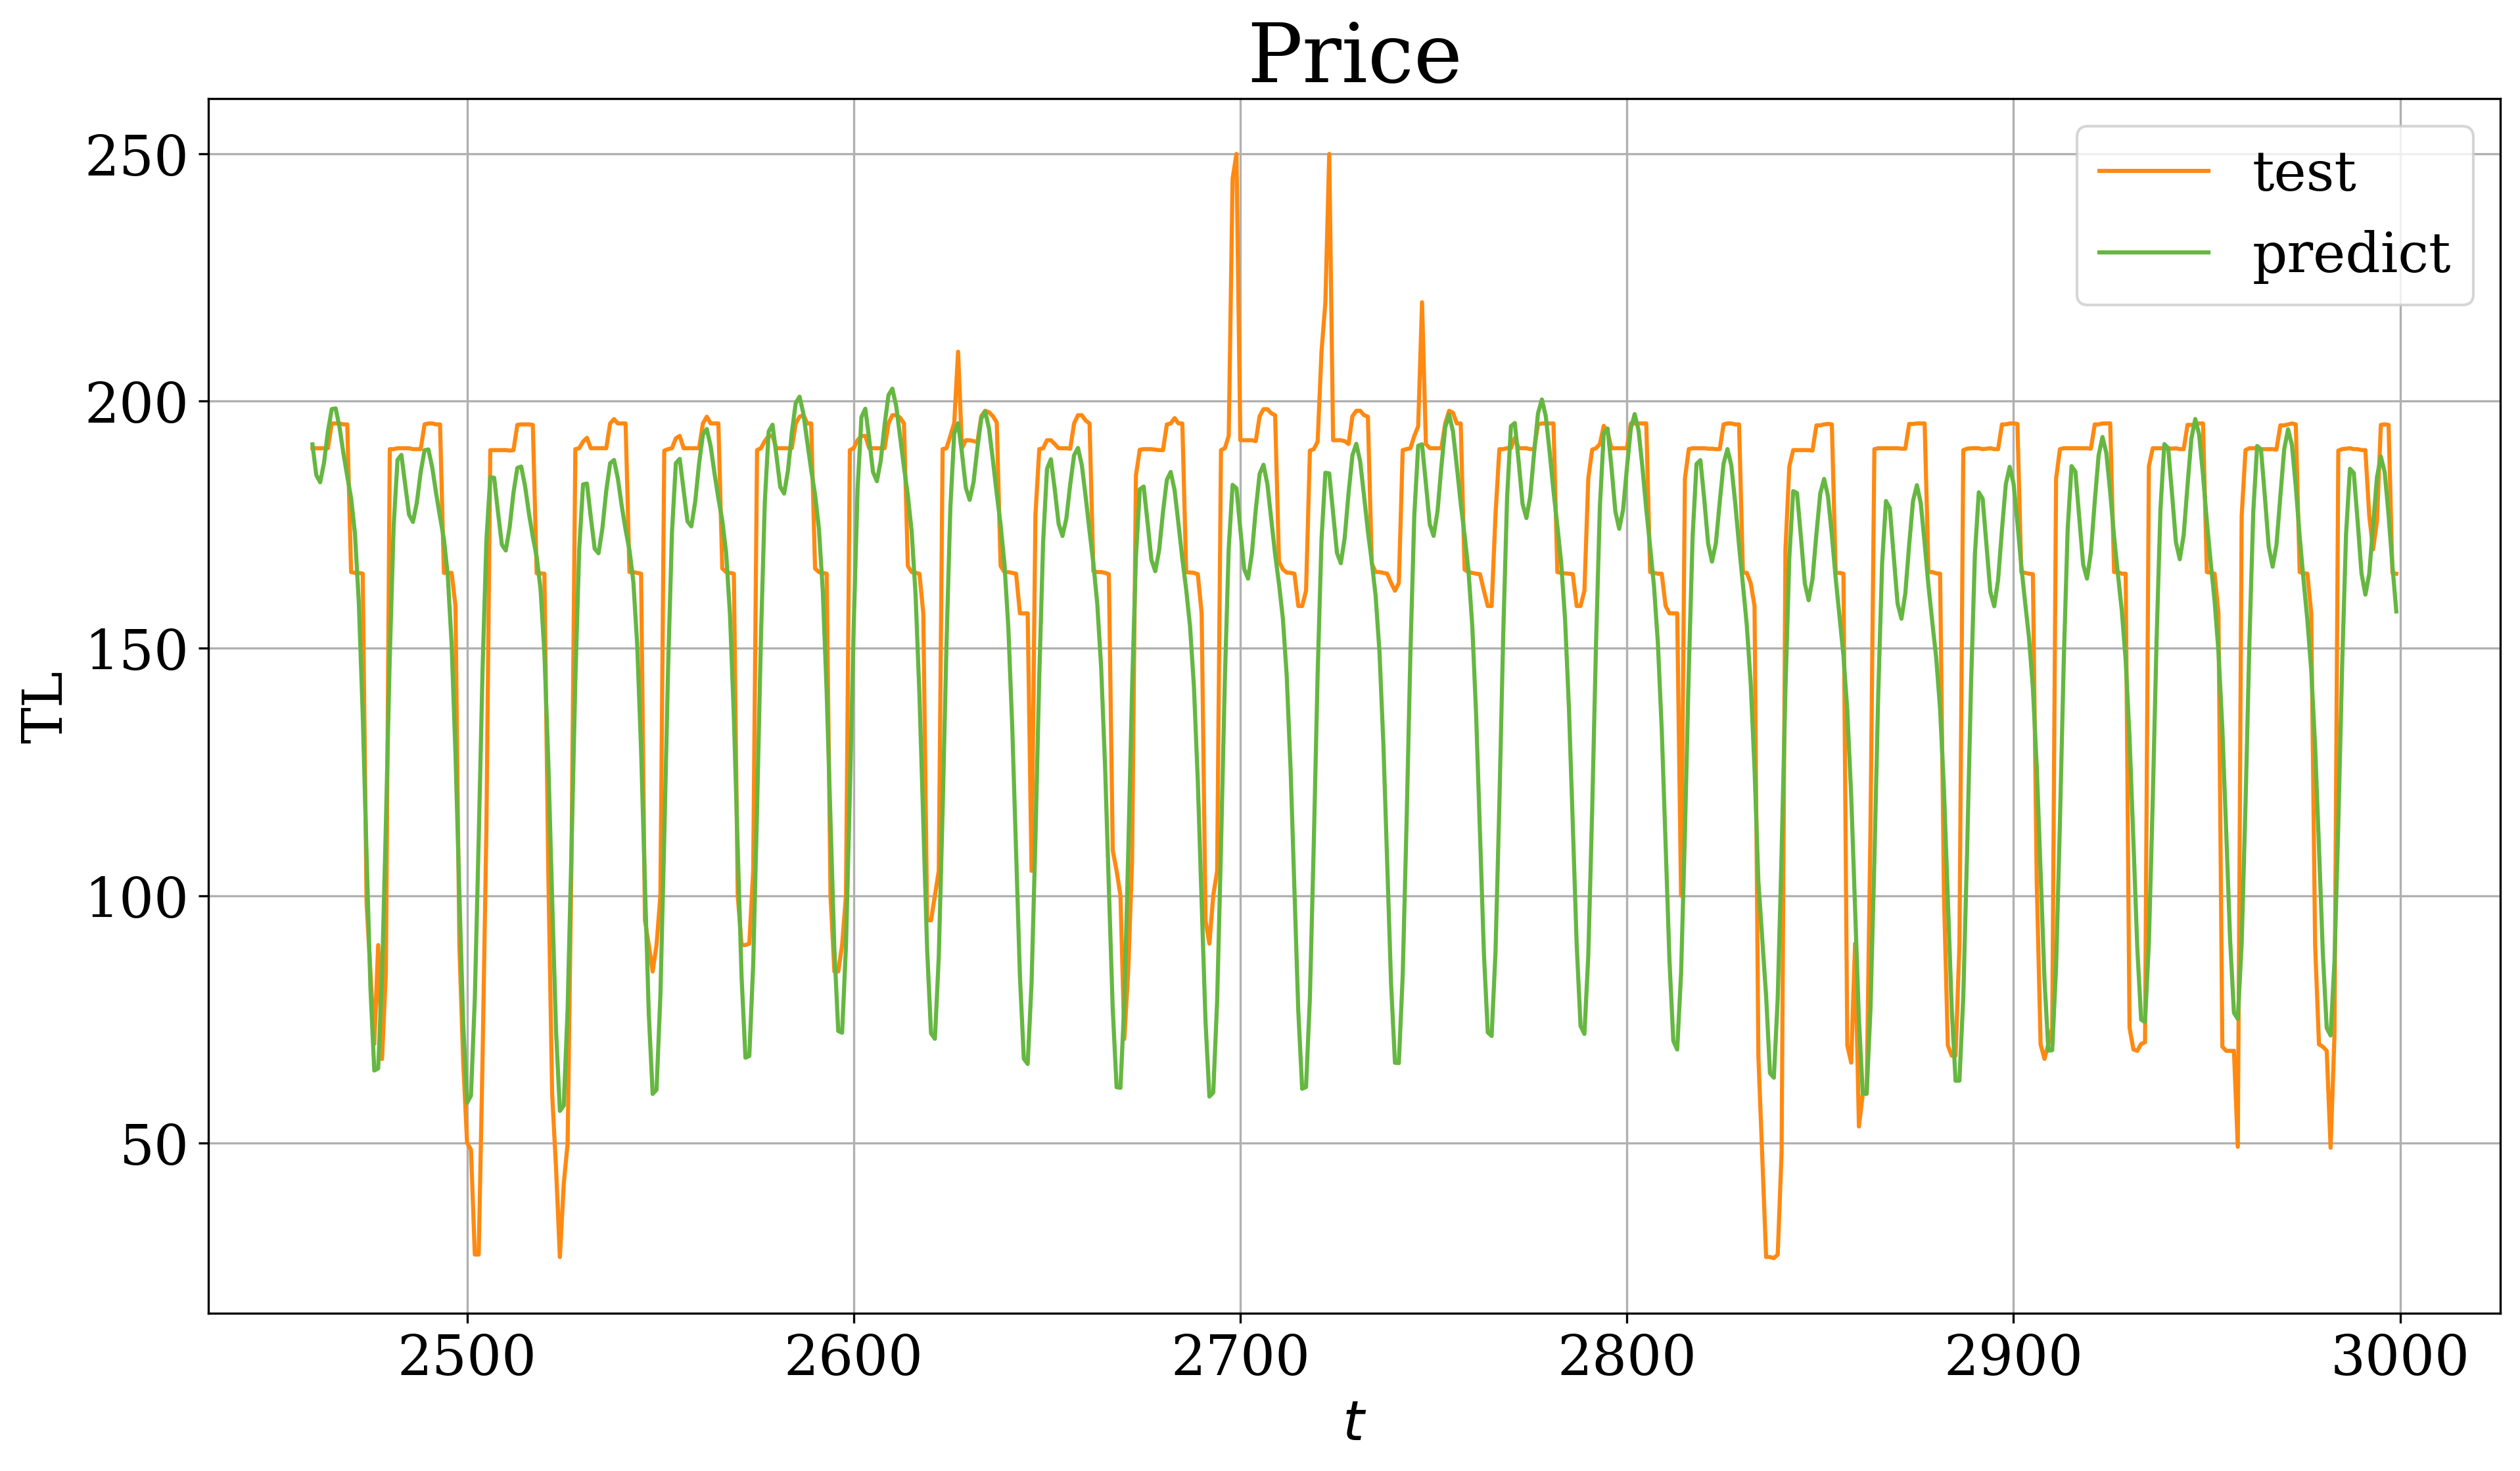

In [19]:
# plot prediction and real values
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(time_grid_test, test_data.T[i], color=color_list[i], label='test')
        ax.plot(time_grid_test, forecast_mssa.T[i], color=color_list[-1], label='predict')

        ax.grid(True)
        ax.legend();
        ax.set_ylabel(f'{sig_units[i]}', fontsize=20)
        ax.set_xlabel('$t$', fontsize=20)
        ax.set_title(f'{sig_names[i]}', fontsize=30)

        fig.savefig(f'./figs/prediction/{sig_names[i].replace(" ", "_")}.eps',
                             format='eps')